## Ideas for noise filters for pep

#### I have some test audio here

this audio only has a little noise, 

a high hiss in the top band

In [2]:
from IPython.display import Audio
import numpy as np
import wave
import soundfile as sf
from matplotlib import pyplot as plt

data = np.empty(0)
#open a wav file
data, samplerate = sf.read('noisy_fish_1.wav')

signal = data
Audio(data, rate=samplerate)



RuntimeError: Error opening 'noisy_fish_1.wav': System error.

### to see what we need to do here is a spectrum of these frequencies

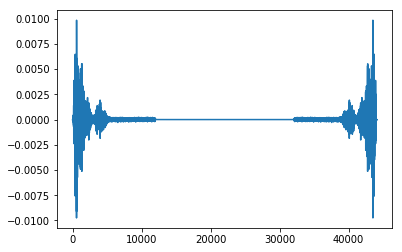

In [97]:
freq_domain_signal = np.fft.ifft(signal[:samplerate])
plt.plot(freq_domain_signal)
plt.show()

### it looks like a low pass with a cutoff ataround 5000 will help

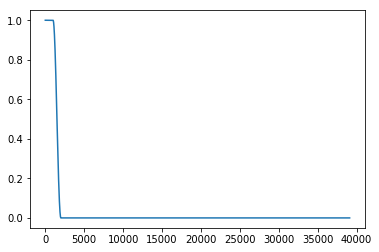

In [98]:
## a window
cutoff = 1000
fltlen = 1000
window = np.append(np.full(cutoff, 1), 1 - np.hanning(2*fltlen)[:fltlen])
#window = np.hanning(2*fltlen)
window = np.append(window, np.full((samplerate)-7000, 0))
#window = np.append(window, np.flip(window))
plt.plot(window)
plt.show()

### the impulse responce of this filter...

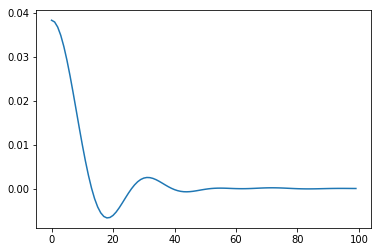

In [99]:
impulse_responce = np.fft.ifft(window)[:100]
plt.plot(impulse_responce)
plt.show()

In [100]:
### im not sure how many of these values to take but it seems that it levels out at around 30
### a 30*n filter would though be very slow
### while testing, the vaiable to change is here

M = 10
B = impulse_responce[:M]

In [101]:
def fir_filter(signal, B):   
    output = np.zeros(len(signal))
    for N in range(len(B), len(signal)):
        for K in range(len(B)):
            output[N] += B[K] * signal[N - K]
    return output

### here we do a test on some noise to see if we have a desired frequency responce

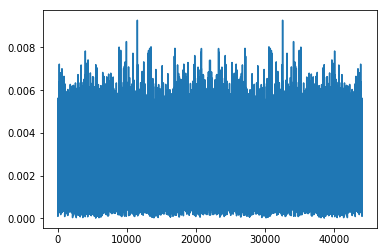

/Users/willj/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


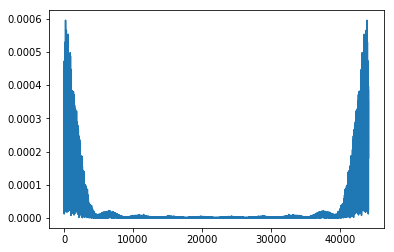

In [102]:
noise = (np.random.rand(samplerate) * 2) - 1
plt.plot(abs(np.fft.ifft(noise)))
plt.show()

plt.plot(abs(np.fft.ifft(fir_filter(fir_filter(noise, B), B))))
plt.show()

/Users/willj/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


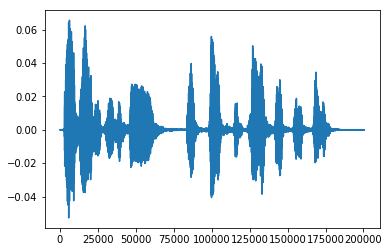

In [103]:
#filter the signal
filtered_signal = fir_filter(fir_filter(signal, B), B)

# plot the result
plt.plot(filtered_signal)
plt.show()


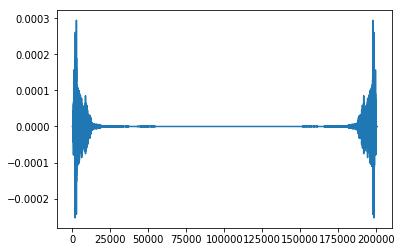

In [104]:
### frequency analysis...

frq_spec_output = np.fft.ifft(filtered_signal)
plt.plot(frq_spec_output)
plt.show()

In [105]:
#the filtered audio
Audio(filtered_signal, rate=samplerate)

## We can try on another example with a greater noise level

this auio is the original with a recording of a train station added to the background

In [106]:
data = np.empty(0)
#open a wav file
data, samplerate = sf.read('speach-to-text/audio/noisy_fish_2.wav')

very_noisy_signal = data
Audio(data, rate=samplerate)

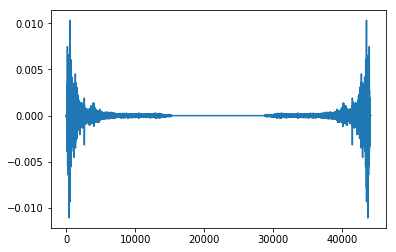

In [107]:
##freq analysis:
freq_domain_signal_2 = np.fft.ifft(very_noisy_signal[:samplerate])
plt.plot(freq_domain_signal_2)
plt.show()

/Users/willj/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


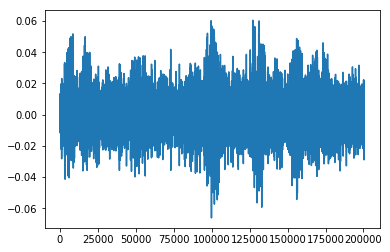

In [108]:
#filter the signal
filtered_signal_2 = fir_filter(fir_filter(very_noisy_signal, B), B)

# plot the result
plt.plot(filtered_signal_2)
plt.show()

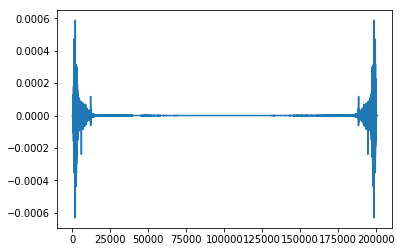

In [109]:
### frequency analysis of the output:

frq_spec_output_2 = np.fft.ifft(filtered_signal_2)
plt.plot(frq_spec_output_2)
plt.show()

In [110]:
#the filtered audio
Audio(filtered_signal_2, rate=samplerate)

### here we still have a lot of noise in the lower frequencies

dealing with this may be harder, it may be possable to introdce a low_pass but there will still be noise in the vocal range

one solution may be to use the back microphone on pepper to assess the noise value

this could be as simple as front mic data -= back mic data, there may though be isues with phase which could be compensated for

## this filter is also remarkably slow when applied in python
## it might well be neccessary to implement this function in C/C++ and run it as a python module

# i will try a more precise bandpass here to deal better with the v_noisy data

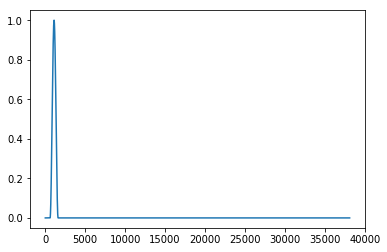

In [258]:
## a window
cutoff = 0
fltlen = 1000
window = np.append(np.full(600, 0), np.hanning(fltlen))
window = np.append(window, np.full(((samplerate)-7000)-600, 0))
#window = np.append(window, np.flip(window))
plt.plot(window)
plt.show()

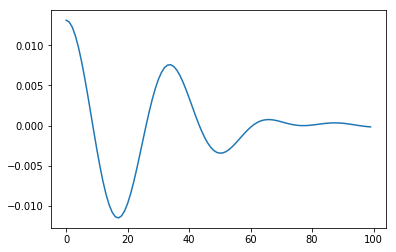

In [259]:
impulse_responce = np.fft.ifft(window)[:100]
plt.plot(impulse_responce)
plt.show()

In [264]:
M = 100
B = impulse_responce[:M]

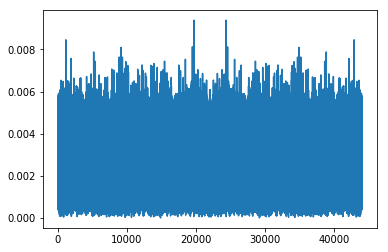

/Users/willj/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


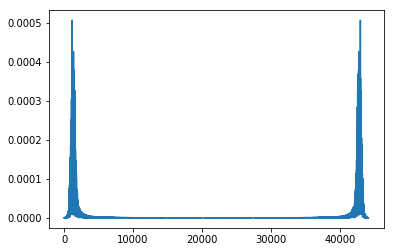

In [265]:
noise = (np.random.rand(samplerate) * 2) - 1
plt.plot(abs(np.fft.ifft(noise)))
plt.show()

plt.plot(abs(np.fft.ifft(fir_filter(fir_filter(noise, B), B))))
plt.show()

/Users/willj/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


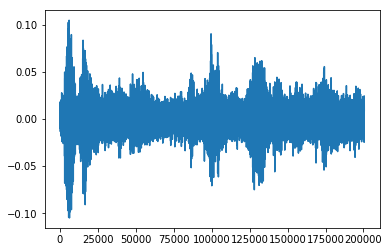

In [266]:
#filter the signal
filtered_signal_3 = fir_filter(very_noisy_signal, B)

# plot the result
plt.plot(filtered_signal_3)
plt.show()

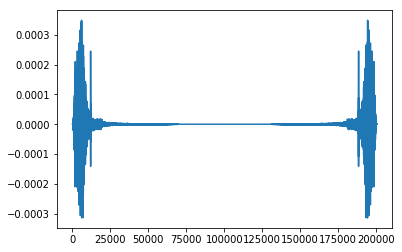

In [267]:
### frequency analysis of the output:

frq_spec_output_3 = np.fft.ifft(filtered_signal_3)
plt.plot(frq_spec_output_3)
plt.show()

In [268]:
#the filtered audio
Audio(filtered_signal_3, rate=samplerate)

the band pass has not made a great difference, the main distruption in noise is coming from other vocal disturbence

i will try sending these examples to wit to see if it can understand anything

In [247]:
import json
import requests

def read_audio(WAVE_FILENAME):

    # function to read audio(wav) file
    with open(WAVE_FILENAME, 'rb') as f:
        if(f):
            audio = f.read()
        else:
            print("file problem")

    return audio

def get_text(file):
    #recieves unparsed text from wit and stores in self.text
    
    API_ENDPOINT = 'https://api.wit.ai/speech'
    ACCESS_TOKEN = 'YKFCHVBM73GXLZUD7MLGA3OENIY4BU7Y'

    # get a sample of the audio that we recorded before. 
    audio = read_audio(file)

    # defining headers for HTTP request
    headers = {'authorization': 'Bearer ' + ACCESS_TOKEN, 'Content-Type': 'audio/wav'}

    #Send the request as post request and the audio as data
    resp = requests.post(API_ENDPOINT, headers = headers, data = audio)

    for things in resp:
        print("a thing: " + things)

    #Get the text
    return json.loads(resp.content)['_text']


In [248]:
print(get_text('fish_clean.wav'))

a thing: {
  "_text" : "i know the human being and fish can coexist peacefully",
  "entities" : { },
  "msg_id" : "1bAAGhIyHd40EALtj"
}
i know the human being and fish can coexist peacefully


In [249]:
print(get_text('fish_lowpass.wav'))

a thing: {
  "_text" : "i don't know why",
  "entities" : { },
  "msg_id" : "1qZvHfAKCcTB28bLF"
}
i don't know why


In [250]:
print(get_text('fish_bandpass.wav'))

a thing: {
  "_text" : "i don't see a",
  "entities" : { },
  "msg_id" : "1izxCs5MurLU3Pmkm"
}
i don't see a


### I can conclude for now that this method works well for low level background noise, it does not deal with the higher level noises as found in the train station recording, this is likely due to the tanoy abouncment in the vocal range during the recording

more test would need to be done to see how effective filtering can be for noisey environments

In [278]:
#nb:

#adding a lopass ontop of a bandpass
## a window
cutoff = 1000
fltlen = 1000
window = np.append(np.full(cutoff, 1), 1 - np.hanning(2*fltlen)[:fltlen])
#window = np.hanning(2*fltlen)
window = np.append(window, np.full((samplerate)-7000, 0))
#window = np.append(window, np.flip(window))
impulse_responce = np.fft.ifft(window)[:100]
M = 10
B = impulse_responce[:M]
filtered_signal_4 = fir_filter(fir_filter(filtered_signal_3, B), B)

/Users/willj/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


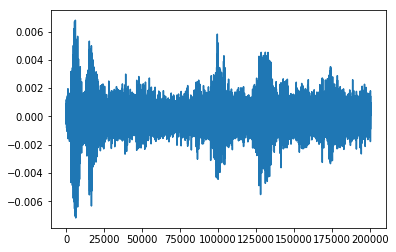

In [279]:
# plot the result
plt.plot(filtered_signal_4)
plt.show()

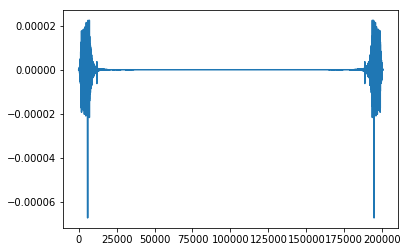

In [280]:
frq_spec_output_4 = np.fft.ifft(filtered_signal_4)
plt.plot(frq_spec_output_4)
plt.show()

In [281]:
Audio(filtered_signal_4, rate=samplerate)

In [286]:
#here is a prototype of the code for a real time filter
#it is not tested
class audio_filter():
    
    def __init__():

        self.passes = None
        self.M = None
        self.B = default_window()
        
        self.last = np.zeros(self.M)
        
    def proccess(signal):
        #there is a much more efficiant way to achieve this.
        #i will find my previouse calculations and apply later
        
        buff = np.append(self.last, signal)
        output = np.zeros(len(signal))
        
        prev = buff
        
        for i in range(self.passes):
        
            #equivilent of calloc
            curr = np.zeros(len(signal))
            
            #apply a pass fo the filter
            for N in range(len(B), len(signal)):
                for K in range(len(B)):
                    curr[N] += B[K] * prev[N - K]
                    
            #reset for next loop if there is a next loop        
            if i < self.passes - 1:
                prev = curr
        
        #this is a copy from the original signal    
        last_vals = signal[len(signal) - self.M:]
        
        return curr
    
    def default_window():
        #low pass
        ## a window
        cutoff = 1000
        fltlen = 1000
        window = np.append(np.full(cutoff, 1), 1 - np.hanning(2*fltlen)[:fltlen])
        window = np.append(window, np.full((samplerate)-7000, 0))
        
        self.passes = 2
        self.M = 10
        
        return np.fft.ifft(window)[:self.M]
    
    def addWindow(window, M, passes):
        
        self.M = M
        self.passes = passes
        self.B = np.fft.ifft(window)[:self.M]
        
        
        